In [2]:
%load_ext lab_black
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pymalts as pm
import networkx as nx
import sklearn.linear_model as lm
import sklearn.tree as tree
import sklearn.svm as svm
import sklearn.ensemble as en
from sklearn.neighbors import NearestNeighbors
import warnings

warnings.filterwarnings("ignore")

path_to_git = "/Users/harshparikh/Documents/GitHub/iic_causal_inference/"

iic_burden = pd.read_pickle(
    path_to_git + "aim1/data_to_fit_CNNIIC_iic_burden_smooth_W300.pickle"
)

iic_burden.keys()

sns.set(font_scale=4, style="whitegrid")


def plot_unit(E, D, Dnames):
    n_drugs = D.shape[1]
    drug_names = Dnames
    fig, axs = plt.subplots(
        nrows=1 + D.shape[1],
        ncols=1,
        sharex=True,
        figsize=(15, 6 + 1.25 * n_drugs),
        gridspec_kw={"height_ratios": [4] + [1 for i in range(D.shape[1])]},
    )
    axs[0].plot(E, c="black", label="Observed")
    axs[0].set_title("IIC Burden")
    for i in range(1, 1 + n_drugs):
        y = D[:, i - 1]
        axs[i].imshow(y[np.newaxis, :], cmap="copper", aspect="auto")
        axs[i].set_title(drug_names[i - 1])


def setup_data(iic_burden, frame=10):
    df = pd.DataFrame(
        iic_burden["C"], columns=iic_burden["Cname"], index=iic_burden["sids"]
    )
    df["mRS"] = iic_burden["Y"]
    n = df.shape[0]
    df_wave = pd.DataFrame()
    for i in range(n):
        try:
            E = iic_burden["Pobs"][i][:frame]
            Ename = ["iic_%d" % (j) for j in range(frame)]
            D = iic_burden["D"][i][:frame, :]
            time_of_intervention = np.argmax(D.sum(axis=1) > 0)
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = frame - 1
            D_flat = D.reshape(-1,)
            Dname_flat = np.array(
                [
                    ["%s_%d" % (drug, j) for drug in iic_burden["Dname"]]
                    for j in range(frame)
                ]
            ).reshape(-1,)
            D_summary = D.sum(axis=0)
            First_D = iic_burden["Dname"][np.argmax(D[time_of_intervention, :])]
            Dname_summary = iic_burden["Dname"]
            E_summary_pre = np.nanmean(E[:time_of_intervention])
            E_summary_post = np.nanmean(E[time_of_intervention:])
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = np.inf
                First_D = 0
                E_summary_post = E_summary_pre
            df_temp = pd.DataFrame(
                [
                    [time_of_intervention]
                    + [First_D]
                    + list(E)
                    + [E_summary_pre, E_summary_post]
                    + list(D_flat)
                    + list(D_summary)
                ],
                index=[df.index[i]],
                columns=["time_of_intervention"]
                + ["drug_administered"]
                + Ename
                + ["avg_iic_pre", "avg_iic_post"]
                + list(Dname_flat)
                + list(Dname_summary),
            )
            #         print(df.index[i],df_temp)
            df_wave = df_wave.append(df_temp)
        except:
            continue
    df = df.join(df_wave)
    return df


def setup_coarsen_data(iic_burden, window=36, summarize="max", **kwargs):
    df = pd.DataFrame(
        iic_burden["C"], columns=iic_burden["Cname"], index=iic_burden["sids"]
    )
    df["mRS"] = iic_burden["Y"]
    n = df.shape[0]
    E_col = []
    D_col = []
    for i in range(n):
        t = len(iic_burden["Pobs"][i])
        if t > window:
            if summarize == "mean":
                E = np.max(
                    [
                        np.nanmean(iic_burden["Pobs"][i][j : j + window])
                        for j in range(t - window)
                    ]
                )
            if summarize == "proportion":
                threshold = kwargs.get("threshold", 0.5)
                E = np.nanmean(
                    np.array(
                        [
                            np.nanmean(iic_burden["Pobs"][i][j : j + window])
                            for j in range(t - window)
                        ]
                    )
                    > threshold
                )
            if summarize == "mean":
                E = np.mean(
                    [
                        np.nanmean(iic_burden["Pobs"][i][j : j + window])
                        for j in range(t - window)
                    ]
                )
            if summarize == "median":
                E = np.mean(
                    [
                        np.nanmedian(iic_burden["Pobs"][i][j : j + window])
                        for j in range(t - window)
                    ]
                )

        else:
            E = np.nanmean(iic_burden["Pobs"][i])
        E_col.append(E)
        D = np.nanmean(iic_burden["D"][i], axis=0)
        D_col.append(D)
    df["E"] = E_col
    df_D = pd.DataFrame(D_col, columns=iic_burden["Dname"], index=df.index)
    df = df.join(df_D, how="inner")
    return df

In [3]:
df_pkpd = pd.read_csv("PD_Parameters_result.csv", index_col=0)
df_pkpd = df_pkpd.fillna(df_pkpd.mean())

print(df_pkpd.shape[0])

df_coarsen = setup_coarsen_data(iic_burden, window=6, summarize="mean")

# df_coarsen_mean = setup_coarsen_data(iic_burden, window=6, summarize="mean")
# df_coarsen_max = setup_coarsen_data(iic_burden, window=6, summarize="max")
# df_coarsen_median = setup_coarsen_data(iic_burden, window=6, summarize="median")

print(df_coarsen.shape[0])

df_coarsen_1 = df_coarsen[
    iic_burden["Cname"]
    + [
        "mRS",
        "E",
        "lacosamide",
        "levetiracetam",
        "midazolam",
        "pentobarbital",
        "phenobarbital",
        "propofol",
        "valproate",
        "lorazepam",
        "diazepam",
        "fosphenytoin",
    ]
].dropna()

print(df_coarsen_1.shape[0])

df_coarsen_1 = df_coarsen_1.join(df_pkpd, how="inner")
print(df_coarsen_1.shape[0])

1310
1323
997
995


In [4]:
cutoff_d = (
    df_coarsen_1[
        [
            "lacosamide",
            "levetiracetam",
            "midazolam",
            "pentobarbital",
            "phenobarbital",
            "propofol",
            "valproate",
            "lorazepam",
            "diazepam",
            "fosphenytoin",
        ]
    ]
).max() / 10

In [100]:
continuous = [
    "Age",
    "iGCS-Total",
    "iGCS = T?",
    "Worst GCS in 1st 24h",
    "Worst GCS intub",
    "APACHE II 1st 24h",
    "SBP highest (1st 24h)",
    "SBP lowest (1st 24h)",
    "DBP highest (1st 24h)",
    "DBP lowest (1st 24h)",
    "HR highest (1std 24h)",
    "HR lowest (1st 24h)",
    "premorbid MRS",
]
discrete = set(iic_burden["Cname"]).difference(continuous)

df_coarsen_1["Y"] = (df_coarsen_1["mRS"] > 3).astype(float)

n_thresholds = 5
thresholds = [-0.000001, 0.02, 0.1, 0.3, 1]  # list(np.linspace(0,1,num=n_thresholds))
gain = 0.25
iic_level = df_coarsen_1["E"] > 2
for threshold in thresholds:
    iic_level = iic_level + (df_coarsen_1["E"] > threshold).astype(int)

# iic_level = iic_level - (gain / 2) * ((iic_level - (gain / 2)) > 0)
drug_level = (
    (df_coarsen_1["levetiracetam"] > cutoff_d["levetiracetam"])
    + (df_coarsen_1["propofol"] > cutoff_d["propofol"])
    + (df_coarsen_1["midazolam"] > cutoff_d["midazolam"])
    + (df_coarsen_1["lacosamide"] > cutoff_d["lacosamide"])
    + (df_coarsen_1["pentobarbital"] > cutoff_d["pentobarbital"])
    + (df_coarsen_1["phenobarbital"] > cutoff_d["phenobarbital"])
    + (df_coarsen_1["diazepam"] > cutoff_d["diazepam"])
    + (df_coarsen_1["fosphenytoin"] > cutoff_d["fosphenytoin"])
    + (df_coarsen_1["valproate"] > cutoff_d["valproate"])
    + (df_coarsen_1["lorazepam"] > cutoff_d["lorazepam"])
).astype(int)

df_coarsen_1["iic"] = iic_level.astype(int).astype(str)
df_coarsen_1["drug"] = drug_level
df_coarsen_1["T"] = (
    "("
    + df_coarsen_1["iic"].astype(str)
    + ", "
    + df_coarsen_1["drug"].astype(str)
    + ")"
)
print(df_coarsen_1.shape[0])

df_race = pd.read_csv("covariates-full.csv", index_col=0)[["Race"]]
df_race = df_race.loc[list(df_coarsen_1.index)]
df_race = pd.get_dummies(df_race)[
    ["Race_Asian", "Race_Black or African American", "Race_White or Caucasian"]
]

df_coarsen_1 = df_coarsen_1.drop(
    columns=["Race_White or Caucasian", "Race_Asian", "Race_Black or African American"],
    errors="ignore",
).join(df_race, how="inner")
print(df_coarsen_1.shape[0])

# df_coarsen_1.to_csv('max_df_coarsen.csv')

995
995


In [101]:
df_coarsen_1["E"].quantile(0.25), df_coarsen_1["E"].quantile(0.5), df_coarsen_1[
    "E"
].quantile(0.75)

(0.013783798242981024, 0.08950045252449154, 0.3127098721527336)

In [102]:
df_coarsen_1.groupby(by="T").count().mean(axis=1)

df_coarsen_1.groupby(by="T").mean()

df_coarsen_1.groupby(by="Y").mean()[
    ["Race_Asian", "Race_Black or African American", "Race_White or Caucasian"]
] * 100
(
    df_coarsen_1.groupby(by="iic").sum()[
        ["Race_Asian", "Race_Black or African American", "Race_White or Caucasian"]
    ]
).iloc[:].rename(
    {
        "%s"
        % (str(i)): "[%.2f,%.2f)"
        % (np.abs(thresholds[i - 1]), np.abs(thresholds[i]))
        for i in range(1, len(thresholds))
    },
    axis="index",
)

,Race_Asian,Race_Black or African American,Race_White or Caucasian
iic,,,
"[0.00,0.02)",6,21,215
"[0.02,0.10)",8,15,177
"[0.10,0.30)",11,23,158
"[0.30,1.00)",8,13,201


# Effect of IIC Burden on Outcome

## Controlling for age

In [11]:
n_repeats = 5
n_splits = 3
df_malts_data = df_coarsen_1[['Age','Y','T']]
discrete = []
m = pm.malts_mf(outcome='Y',
                treatment='T', 
                data=df_malts_data,
                n_repeats=n_repeats,
                n_splits=n_splits,
                output_format='full',
                k_tr=2,
                k_est=4,
                discrete = discrete,
                C=0.01)

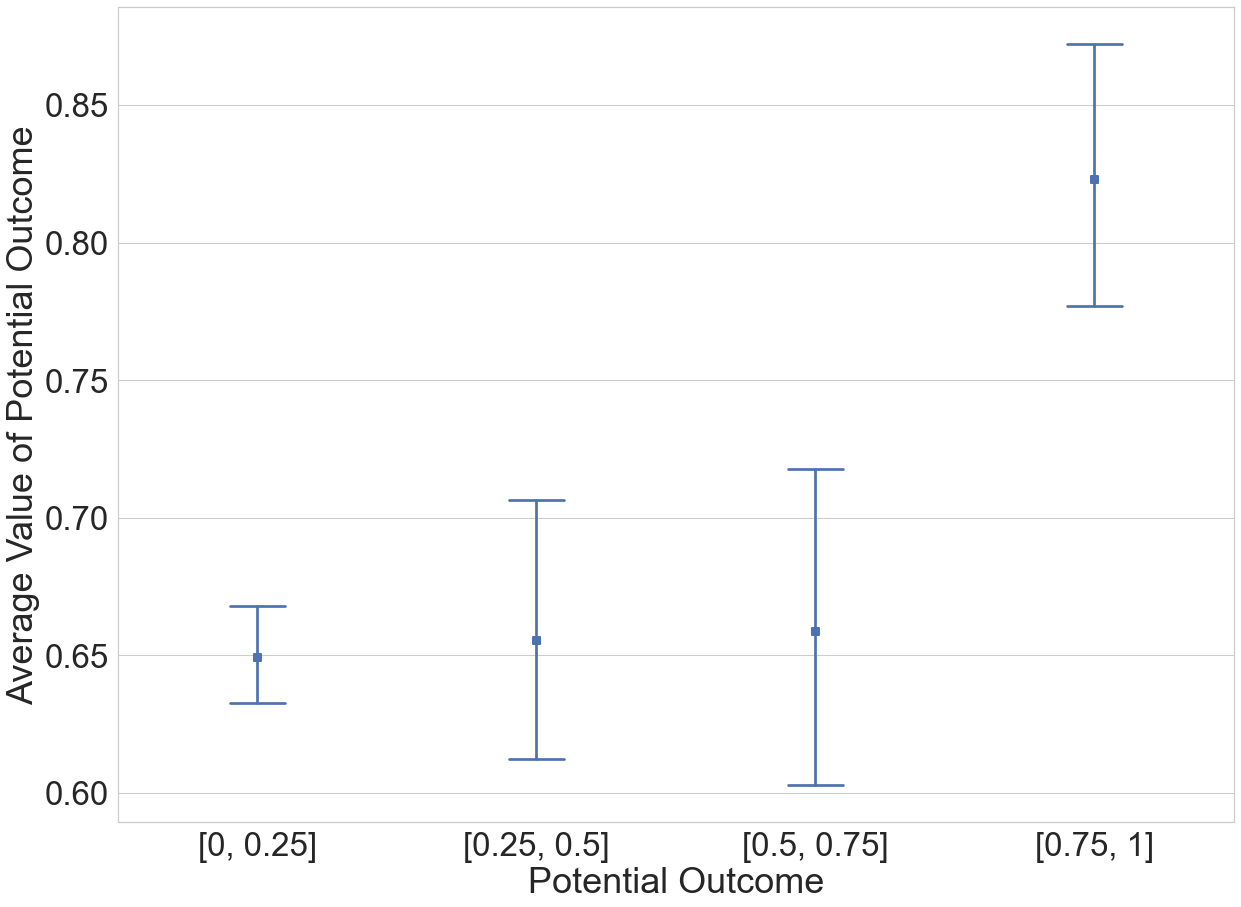

In [12]:
out_age = m.CATE_df.drop(columns = ['Y','T'])#.T.groupby(level=0).mean().T
out_age.to_csv('new_mean_age.csv')
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in thresholds[1:]]
apo_0_age = out_age[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in thresholds[1:]]
apo_1_age = out_age[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in thresholds[1:]]
diam_0_age = out_age[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in thresholds[1:]]
diam_1_age = out_age[columns]

apo_tight_0_age = pd.DataFrame(apo_0_age.values*(diam_0_age<10).astype(int).replace(0, np.nan).values,
                         index=apo_0_age.index,columns=apo_0_age.columns)
apo_tight_0_age.mean(axis=0)

apo_tight_1_age = pd.DataFrame(apo_1_age.values*(diam_1_age<10).astype(int).replace(0, np.nan).values,
                         index=apo_1_age.index,columns=apo_1_age.columns)
apo_tight_1_age.mean(axis=0)

fig,ax = plt.subplots(figsize=(20,15))
sns.pointplot(data=apo_tight_0_age.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax,join=False,capsize=.2,markers=['s'], markersize=520)
plt.xlabel('Potential Outcome')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
fig.savefig('new_mean_age.png')

In [13]:
apo_tight_0_age.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}).dropna().to_csv('average_te_mean_age.csv')

In [14]:
['Y((%f, 0))'%(threshold-gain/2) for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]

['Y((0.125000, 0))',
 'Y((0.375000, 0))',
 'Y((0.625000, 0))',
 'Y((0.875000, 0))']

## Controlling for All Preadmission Covariates

In [37]:
n_repeats = 5
n_splits = 3
df_malts_data = df_coarsen_1[iic_burden['Cname']+['Race_Asian', 'Race_Black or African American', 'Race_White or Caucasian']+['Y','T']]
discrete = list(set(iic_burden['Cname']).difference(continuous))

m_c = pm.malts_mf(outcome='Y',
                treatment='T', 
                data=df_malts_data,
                n_repeats=n_repeats,
                n_splits=n_splits,
                output_format='full',
                k_tr=2,
                k_est=4,
                discrete = discrete,
                C=0.01)

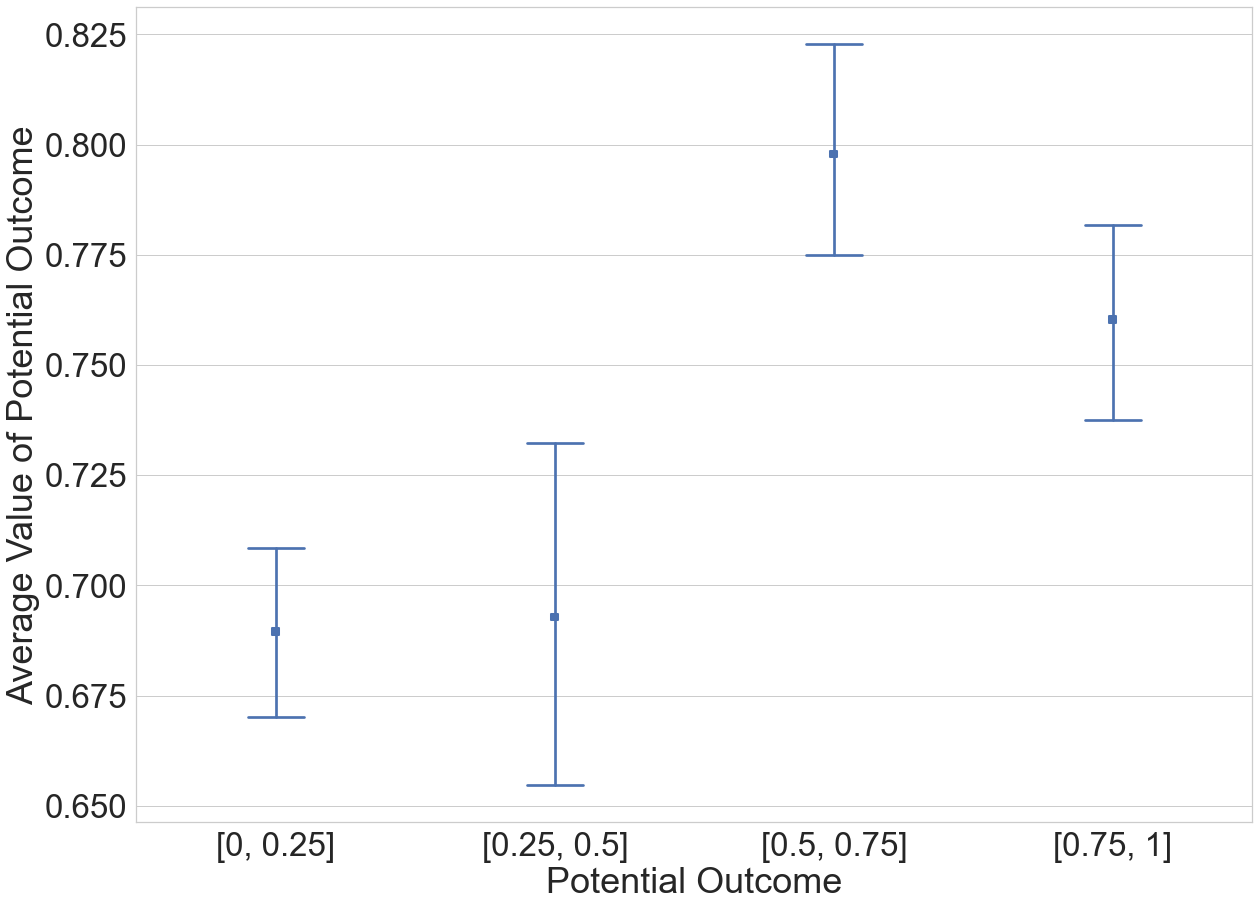

In [38]:
out_c = m_c.CATE_df.drop(columns = ['Y','T'])#.T.groupby(level=0).mean().T
out_c.to_csv('new_mean_c.csv')
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_0_c = out_c[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_1_c = out_c[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_0_c = out_c[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_1_c = out_c[columns]

apo_tight_0_c = pd.DataFrame(apo_0_c.values*(diam_0_c<700).astype(int).replace(0, np.nan).values,
                         index=apo_0_c.index,columns=apo_0_c.columns)
apo_tight_0_c.mean(axis=0)

apo_tight_1_c = pd.DataFrame(apo_1_c.values*(diam_1_c<700).astype(int).replace(0, np.nan).values,
                         index=apo_1_c.index,columns=apo_0_c.columns)
apo_tight_1_c.mean(axis=0)

fig,ax = plt.subplots(figsize=(20,15))
sns.pointplot(data=apo_tight_0_c.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax,join=False,capsize=.2,markers=['s'], markersize=520)
plt.xlabel('Potential Outcome')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
fig.savefig('new_mean_c.png')

In [39]:
apo_tight_0_c.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}).dropna().to_csv('average_te_mean_c.csv')

# Controlling for all pre-admission covariates and PKPD parameters

In [103]:
n_repeats = 5
n_splits = 3
df_malts_data = df_coarsen_1[
    iic_burden["Cname"]
    + ["Race_White or Caucasian"]
    + list(df_pkpd.columns)
    + ["Y", "T"]
]
discrete = list(
    set(
        iic_burden["Cname"]
        + ["Race_Asian", "Race_Black or African American", "Race_White or Caucasian"]
    ).difference(continuous)
)
m = pm.malts_mf(
    outcome="Y",
    treatment="T",
    data=df_malts_data,
    n_repeats=n_repeats,
    n_splits=n_splits,
    output_format="full",
    k_tr=3,
    k_est=5,
    discrete=discrete,
    C=0.01,
)

In [104]:
pd.concat(m.M_opt_list).to_csv("M_opt_mean.csv")

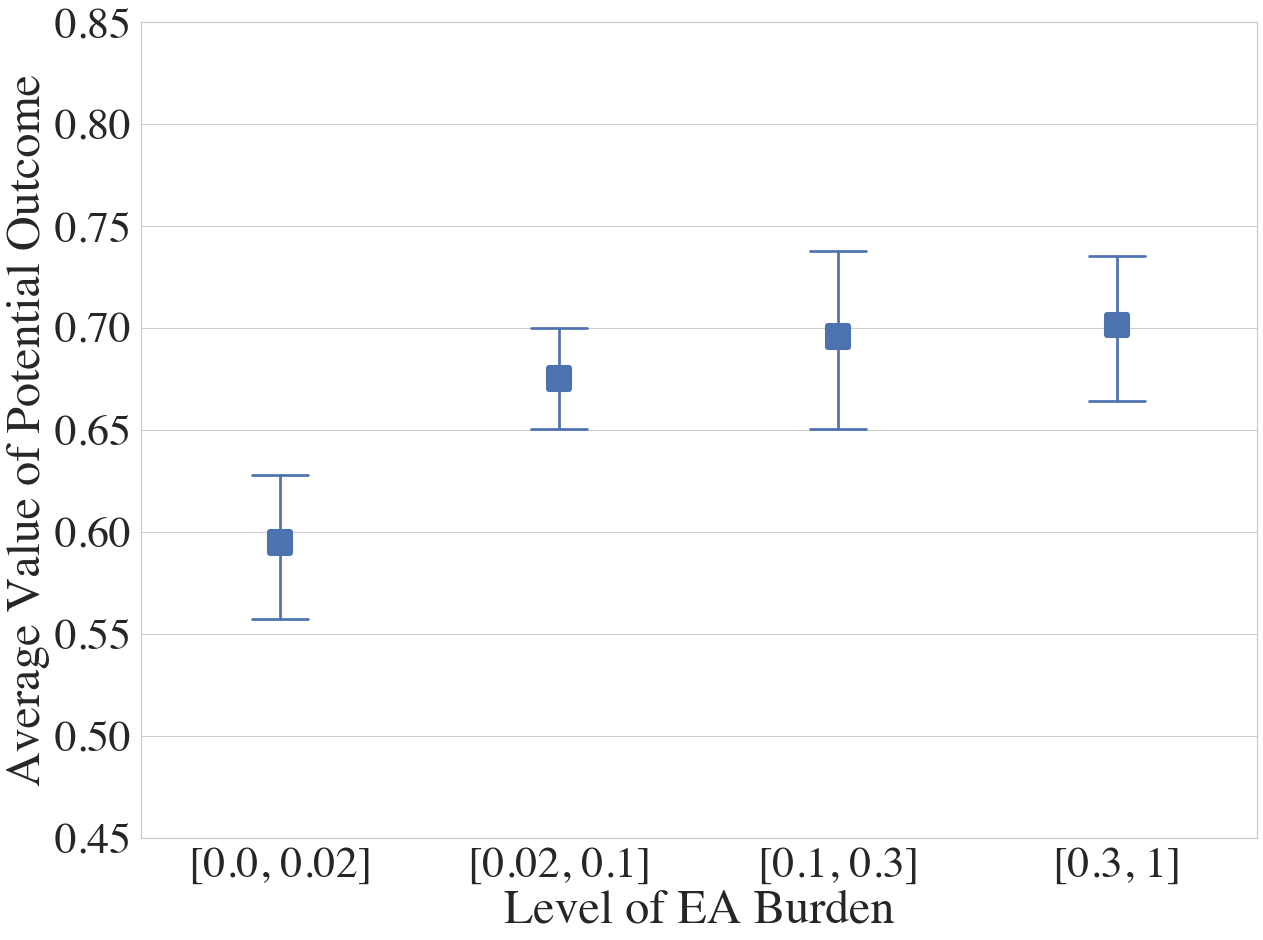

In [109]:
out = m.CATE_df.drop(columns=["Y", "T"])  # .T.groupby(level=0).mean().T
out.to_csv("new_mean_c_pkpd.csv")
columns = ["Y((" + str(i) + ", 0))" for i in range(1, len(thresholds))]
apo_0_c_pkpd = out[columns]
columns = ["Y((" + str(i) + ", 1))" for i in range(1, len(thresholds))]
apo_1_c_pkpd = out[columns]
columns = ["diameter((" + str(i) + ", 0))" for i in range(1, len(thresholds))]
diam_0_c_pkpd = out[columns]
columns = ["diameter((" + str(i) + ", 1))" for i in range(1, len(thresholds))]
diam_1_c_pkpd = out[columns]

apo_tight_0_c_pkpd = pd.DataFrame(
    apo_0_c_pkpd.values * (diam_0_c_pkpd < 2000).astype(int).replace(0, np.nan).values,
    index=apo_0_c_pkpd.index,
    columns=apo_0_c_pkpd.columns,
)
apo_tight_0_c_pkpd.mean(axis=0)

apo_tight_1_c_pkpd = pd.DataFrame(
    apo_1_c_pkpd.values * (diam_1_c_pkpd < 1000).astype(int).replace(0, np.nan).values,
    index=apo_1_c_pkpd.index,
    columns=apo_0_c_pkpd.columns,
)
apo_tight_1_c_pkpd.mean(axis=0)

fig, ax = plt.subplots(figsize=(20, 15))
sns.pointplot(
    data=apo_tight_0_c_pkpd.mean(axis=0)
    .reset_index()
    .rename(columns={0: "Average Potential Outcome"}),
    x="index",
    y="Average Potential Outcome",
    ax=ax,
    join=False,
    capsize=0.2,
    markers=["s"],
    scale=3,
    errorbar=0.65,
)
# sns.lineplot(data=apo_tight_1_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax,ci='sd')
plt.xlabel("Level of EA Burden")
plt.ylabel("Average Value of Potential Outcome")
plt.ylim((0.45, 0.85))
plt.xticks(
    np.arange(len(thresholds) - 1),
    [
        str([np.abs(np.round(thresholds[i - 1], 2)), thresholds[i]])
        for i in range(1, len(thresholds))
    ],
)
# plt.title("Controlling for Preadmission\n Covariates and Pharmacodynamics")
fig.savefig("new_mean_c_pkpd.png")

In [116]:
(
    (
        pd.DataFrame(apo_tight_0_c_pkpd.mean(axis=0))
        .reset_index()
        .groupby("index")
        .mean()
        - 0.59473
    )
    * 100
    / 0.5948
).round(2)

,0
index,
"Y((1, 0))",0.00
"Y((2, 0))",13.52
"Y((3, 0))",17.01
"Y((4, 0))",17.97


In [43]:
apo_tight_0_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}).dropna().to_csv('average_te_mean_c_pkpd.csv')len

In [44]:
apo_tight_0_age = pd.read_csv("average_te_mean_age.csv", index_col=0)
apo_tight_0_c = pd.read_csv("average_te_mean_c.csv", index_col=0)
apo_tight_0_c_pkpd = pd.read_csv("average_te_mean_c_pkpd.csv", index_col=0)

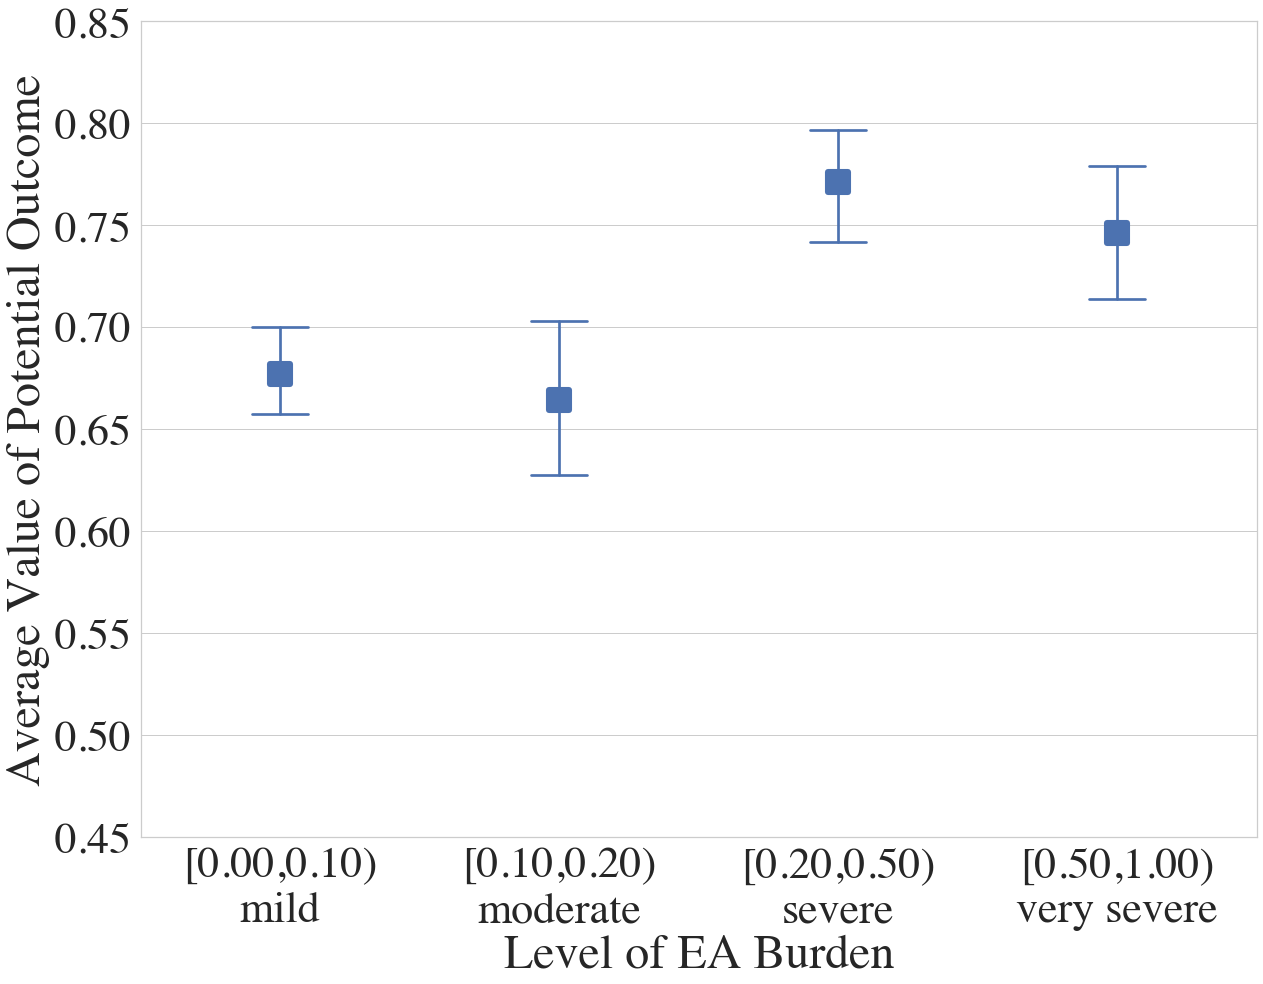

In [53]:
sns.set(font_scale=4, style="whitegrid")
from matplotlib import rc

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=False)

fig, ax = plt.subplots(figsize=(20, 15))
control = [
    "Preadmission Covariate\n and PKPD Parameters"
]  # ,'Preadmission Covariate','Age']
df_apo = [apo_tight_0_c_pkpd, apo_tight_0_c]  # ,apo_tight_0_age]
df_plot = pd.DataFrame()
for i in range(1):
    df_plot_ = df_apo[i]
    df_plot_["Controlling For"] = [control[i] for k in range(df_plot_.shape[0])]
    df_plot = df_plot.append(df_plot_)

sns.pointplot(
    data=df_plot,
    x="index",
    y="Average Potential Outcome",
    hue="Controlling For",
    ax=ax,
    join=False,
    capsize=0.2,
    markers=["s", "o", "v"],
    scale=3,
    errorbar=0.65,
)
# sns.lineplot(data=apo_tight_0_c.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax)
# sns.lineplot(data=apo_tight_0.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax)
# sns.lineplot(data=apo_tight_1_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax,ci='sd')
# plt.legend(['Preadmission Covariate\n and PKPD Parameters','Preadmission Covariate','Age'],title="Controlling for")
# plt.axhline(0.676, c="black", ls="--", lw=3)
plt.xlabel("Level of EA Burden")
plt.ylabel("Average Value of Potential Outcome")
plt.ylim((0.45, 0.85))
level_eng = ["mild", "moderate", "severe", "very severe"]
plt.xticks(
    np.arange(len(thresholds) - 1),
    [
        "[%.2f,%.2f)\n%s" % (np.abs(thresholds[i - 1]), thresholds[i], level_eng[i - 1])
        for i in range(1, len(thresholds))
    ],
)
plt.legend([], [], frameon=False)
fig.savefig("c_pkpd_mean.png")

# Heterogeneous Effects

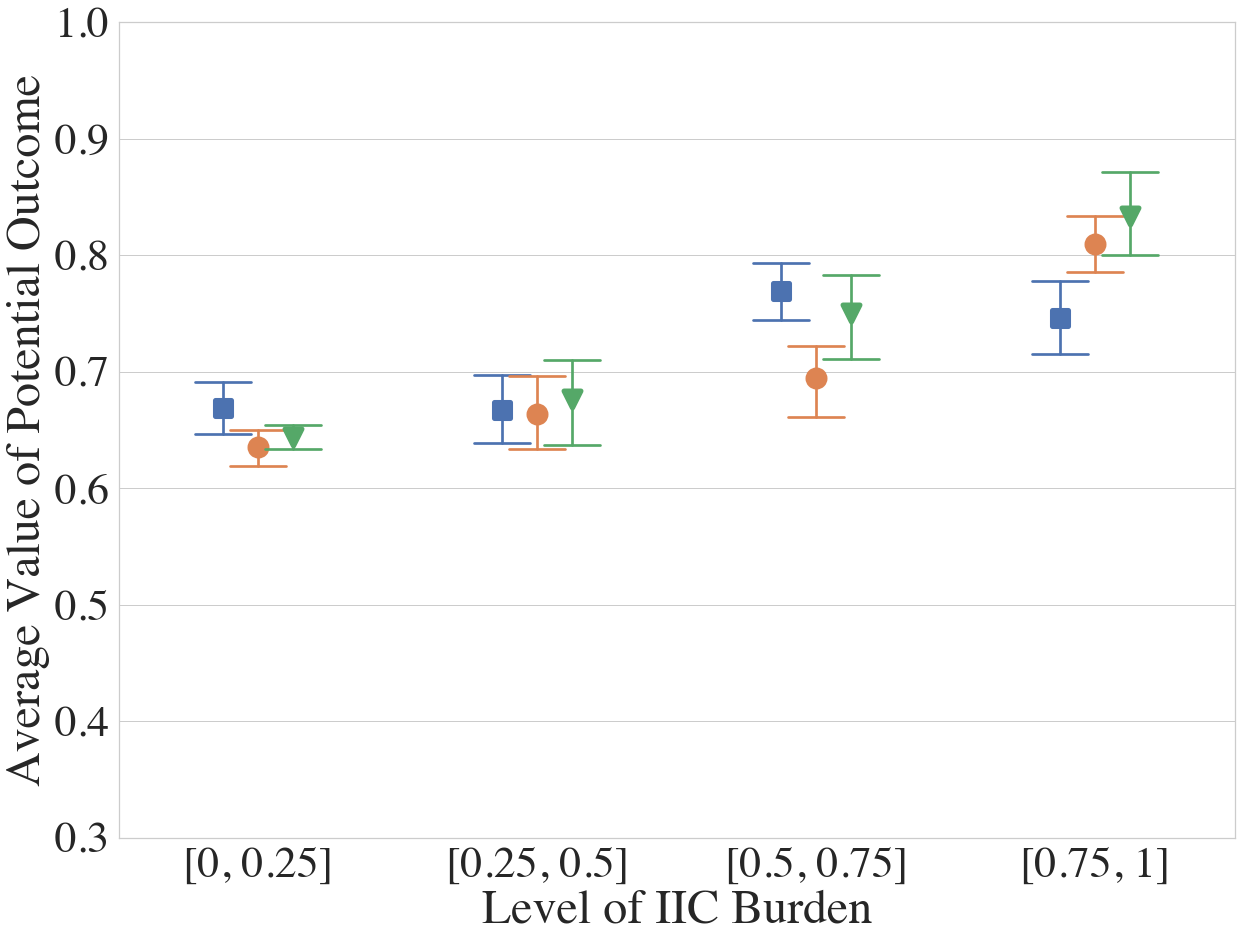

In [28]:
max_logit = pd.read_csv('max_logistics_ates.csv',index_col=0).replace({'No Control':'Naive Difference of Means','Logistic Regression':'Prediction Modeling (Logistic Regression)','Controlling for Everything':'Causal Estimation (MALTS)'})
mean_log = pd.read_csv('mean_logistics_ates.csv',index_col=0).replace({'No Control':'Naive Difference of Means','Logistic Regression':'Prediction Modeling (Logistic Regression)','Controlling for Everything':'Causal Estimation (MALTS)'})

fig,ax = plt.subplots(figsize=(20,15))
sns.pointplot(data=mean_log,x='IIC_Burden',y='Value',hue='Control',
              hue_order=['Causal Estimation (MALTS)','Naive Difference of Means','Prediction Modeling (Logistic Regression)'],
              ax=ax,join=False,
             capsize=.2,markers=['s','o','v'],dodge=0.25,scale = 2.5)
plt.xlabel('Level of IIC Burden')
plt.ylabel('Average Value of Potential Outcome')
plt.ylim((0.3,1))
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
plt.legend(title=None)
plt.legend([],[], frameon=False)
fig.savefig('mean_reg.png')